In [1]:
import numpy as np 
import cv2 as cv
import sys
import math
from tdmclient import ClientAsync
from set_up import initialization, RepeatedTimer 
from obstacle_detection import find_obstacles
from path_planning import get_graph_features, find_path, draw_graph, draw_path
from thymio_state import update_thymio_state, get_thymio_state
from path_following import update_motor, goal_reached, motors, update_instant_target
from local_avoidance import is_obstacle, avoid_obstacle 

In [2]:
client = ClientAsync()
node = await client.wait_for_node()
await node.lock()

Node c840c803-5e0f-416f-ae5d-a54e0adeec35

In [3]:
video = cv.VideoCapture(2) # for using CAM
# Exit if video not opened.
if not video.isOpened():
    print("Could not open video")
    sys.exit()
# Read first frame.
ok, initial_frame = video.read()
if not ok:
    print('Cannot read video file')
    sys.exit()

# Select bounding box containing rectangle with an area of 1/4 of an A4 sheet:
print("Select bounding box containing rectangle with an area of 1/4 of an A4 sheet :")
A4_box = cv.selectROI(initial_frame, False)
cv.destroyAllWindows()
video.release()

# Set the coefficient to pass from meter to pixel :
length_m = 4*math.sqrt(155.925)*(10**(-2))
length_pix = 2*+A4_box[3] + 2*A4_box[2]
m2pix_coeff = length_pix/length_m
print("m2pix_coeff : ", m2pix_coeff)

Select bounding box containing rectangle with an area of 1/4 of an A4 sheet :
m2pix_coeff :  524.5458116138587


In [4]:
# Main
m2pix_coeff = 508.52914561038216
async def main():
    sampling_time = 0.1     # sampling time   
    speed_target =  100     # desired speed
    tol = 30                # [pixels]
    
    # Initialisation of the environment :
    video, tracker, ok, start, goal, initial_frame, bbox, background_color = initialization()
    frame = initial_frame.copy()
    
    # Pre-process first frame to remove Thymio :
    image = initial_frame.copy()
    image[bbox[1]:bbox[1]+bbox[3], bbox[0]:bbox[0]+bbox[2], :]  = background_color
    
    # Find obstacles and expand them by half of the thymio size:
    obstacles = find_obstacles(image, number_of_colors = 2, m2pix_coeff = m2pix_coeff)
    
    # Find path from start to goal :
    path_coords = find_path(start, obstacles, goal)
    
    # Display the visibility graph and path on initial frame :
    nodes, edges = get_graph_features(start, obstacles, goal)
    initial_frame = draw_graph(initial_frame, nodes, edges)
    initial_frame = draw_path(initial_frame, path_coords)
    cv.imshow("Visibility graph and path", initial_frame)
    cv.waitKey(0)
    cv.destroyAllWindows()
    
    ############################################################
    
    await node.wait_for_variables()
    
    i = 1
    # Initialization :
    thymio_state = []
    instant_target = []
    delta_target = []
    
    # Update Thymio state :
    state_check, angle, center = get_thymio_state(frame, bbox)
    while not state_check :
        # Read a new frame
        ok, frame = video.read()
        if not ok:
            break
        
        # Update tracker
        ok, bbox = tracker.update(frame)
        if ok:
            # Tracking success
            pass
        else :
            # Tracking failure
            cv.putText(frame, "Tracking failure detected", (100,80), cv.FONT_HERSHEY_SIMPLEX, 0.75,(0,0,255),2)
        
        # Update Thymio state :
        state_check, angle, center = get_thymio_state(frame, bbox)
        
        # Display result
        draw_path(frame, path_coords)
        cv.imshow("Tracking", frame)
        
    thymio_state.append((center[0], center[1], angle))
    
    # Display result
    cv.imshow("Tracking", initial_frame)
    
    x_meas = []
    x_meas.append(thymio_state[-1])
    
    # Set initial estimated state :
    x_est = [np.array([thymio_state[-1][0], thymio_state[-1][1], thymio_state[-1][2]])]
    P_est = [1000 * np.ones(3)]
    
    start_i = [np.array(path_coords[i-1])]
    goal_i = [np.array(path_coords[i])]
    
    target_new, delta_new = update_instant_target(start_i[-1], goal_i[-1], speed_target, sampling_time)
    instant_target.append(target_new)
    delta_target.append(delta_new)
    
    rt = RepeatedTimer(sampling_time, update_motor, thymio_state, x_meas, x_est, P_est, instant_target, delta_target, goal_i, m2pix_coeff, node, sampling_time)
    
    while not goal_reached(goal, tol, x_est[-1]):
        await client.sleep(1/100)
        #######################################################
        # Local avoidance :
        if is_obstacle(node) :
            rt.stop()
            while is_obstacle(node) :
                avoid_obstacle(speed_target, node)
                await client.sleep(1/100)
                
                # Read a new frame
                ok, frame = video.read()
                if not ok:
                    break
                # Update tracker
                ok, bbox = tracker.update(frame)
                if ok:
                    # Tracking success
                    pass
                else :
                    # Tracking failure
                    cv.putText(frame, "Tracking failure detected", (100,80), cv.FONT_HERSHEY_SIMPLEX, 0.75,(0,0,255),2)
                    
                # Update Thymio state :
                update_thymio_state(frame, bbox, thymio_state)
                
                # Display result
                draw_path(frame, path_coords)
                cv.imshow("Tracking", frame)
            
            # Set initial estimated state :
            x_est = [np.array([thymio_state[-1][0], thymio_state[-1][1], thymio_state[-1][2]])]
            P_est = [1000 * np.ones(3)]
            
            start_i = [np.array([thymio_state[-1][0], thymio_state[-1][1]])]
            goal_i = [np.array(path_coords[i])]
            
            target_new, delta_new = update_instant_target(start_i[-1], goal_i[-1], speed_target, sampling_time)
            instant_target.append(target_new)
            delta_target.append(delta_new)
            
            x_meas.append(thymio_state[-1])
            rt = RepeatedTimer(sampling_time, update_motor, thymio_state, x_meas, x_est, P_est, instant_target, delta_target, goal_i, m2pix_coeff, node, sampling_time)
            
        ###################################################
        # Read a new frame
        ok, frame = video.read()
        if not ok:
            break
        # Update tracker
        ok, bbox = tracker.update(frame)
        if ok:
            # Tracking success
            pass
        else :
            # Tracking failure
            cv.putText(frame, "Tracking failure detected", (100,80), cv.FONT_HERSHEY_SIMPLEX, 0.75,(0,0,255),2)
        
        # Update Thymio state :
        update_thymio_state(frame, bbox, thymio_state)
        
        # Display result
        draw_path(frame, path_coords)
        cv.imshow("Tracking", frame)
        
        ############################################################
        
        if goal_reached(goal_i[-1], tol, x_est[-1]):
            i = i+1
            if i == len(path_coords): 
                break
            start_i.append(np.array(path_coords[i-1]))
            goal_i.append(np.array(path_coords[i]))
            target_new, delta_new = update_instant_target(start_i[-1], goal_i[-1], speed_target, sampling_time)
            instant_target.append(target_new)
            delta_target.append(delta_new)
        # Exit if ESC pressed
        if cv.waitKey(1) & 0xFF == ord('q'): # if press SPACE bar
            break
    
    # Close everything and exit :
    rt.stop()
    node.send_set_variables(motors(0, 0))
    video.release()
    cv.destroyAllWindows()
    return path_coords, thymio_state, x_est

In [6]:
path_coords, thymio_state, x_est = await main()

Select bounding box containing the Thymio
Select goal position
Select bounding box containing background only


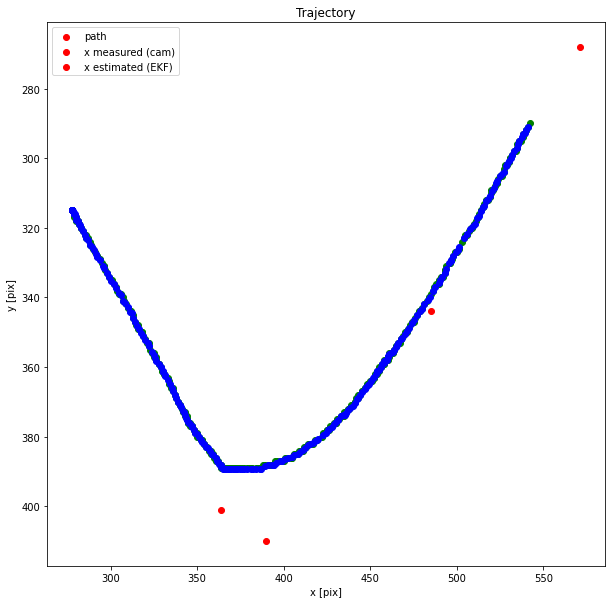

In [5]:
import matplotlib.pyplot as plt
# Plot results :
plt.figure(figsize=(10,10))
plt.title("Trajectory")
plt.xlabel("x [pix]")
plt.ylabel("y [pix]")

for node in path_coords :
    plt.scatter(node[0], node[1], marker="o", color="r")
for state in thymio_state:
    plt.scatter(state[0], state[1], marker="o", color="g")
for i in range(len(x_est)-1):
    plt.scatter(x_est[i+1][0], x_est[i+1][1], marker="o", color="b")

plt.legend(['path', 'x measured (cam)', 'x estimated (EKF)'])
plt.gca().invert_yaxis()